## GMM vs DNN frame recognition from pretrained models

+ ###### Authors: Bob Van Dyck, Dirk Van Compernolle
+ ###### History:  04/2022, 17/03/2023
+ ###### Requires: pyspch v0.7   

Content:
- Training of GMMs for all phonemes
- Frame CLassification
- Applying the models for utterance analysis


In [ ]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [1]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
from pyspch.stats import GMM
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)
logging.basicConfig(level=logging.INFO)

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.nn
from pyspch.stats import GMM
import pyspch.core as Spch

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"
    


In [2]:
#@title Auxiliary functions 

# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename, new_read_path=None, old_read_path='/users/spraak/spchlab/public_html/data/timit/'):
    
    # load module
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)

    # replace esat_path with root_url
    if new_read_path is not None:
        for k, v in setup.items():
            if type(v) == str:
                setup[k] = v.replace(old_read_path, new_read_path)
            
    return setup

def get_pickle(filename):
    picklefile = open(filename, 'rb')
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

In [3]:
# Utility for importing TIMIT test database
timit_root = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
def get_timit_test_data(subcorpus="",ftrs_in="mfcc13",alphabet='timit41',feature_args={}):
    '''
    get (part of) TIMIT corpus from disk
    and process all features for the defined feature extraction
    
    subcorpus:     "", "_mini", "_dr1"   for full, mini(10%), single subdirectory dr1
    ftrs_in:       type of preprocessed features to start from
    alphabet:      choice of alphabet to use  (TIMIT61 should be convertable to it)
    feature_args:  definition of desired feature extraction, should be compatible with  ftrs_in
    '''
    #

    corpus_path = timit_root + 'conf/'
    test_corpus_file = corpus_path + 'timit_test'+subcorpus+'.corpus'
    feature_path = timit_root + 'features/'+ ftrs_in + '/'
    test_pickle_file = feature_path + 'test.pkl'
    test_corpus = pyspch.read_txt(test_corpus_file)
    test_df = pd.read_pickle(test_pickle_file)
    test_data = pyspch.core.DataFrame_to_SpchData(test_df, delete_df=True) 
    test_data = test_data.subset(test_corpus) 
    ##
    # evaluate what postprocessing is needed en do it
    read_feature_args = pyspch.read_json(feature_path + 'feature_args.json')
    modify_feature_args = pyspch.dct_diff(read_feature_args, feature_args)
    test_data.modify_features(modify_feature_args) 
    ##
    # map originial TIMIT 61 transcriptions to the chosen alphabet
    classes = pyspch.timit.get_timit_alphabet(alphabet)
    lab2classes = pyspch.timit.get_timit_mapping('timit61'+'_'+alphabet) 
    test_data.modify_labels(lab2classes) # timit61 -> timit41
    
    return(test_data)

In [4]:
def plot_probs(probs, labels,  fig, iax=2, x0=0., title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## !! only works properly for starting frame = 0
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,linewidths=1,linecolor='k')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.])
        fig.axes[iax].legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

In [5]:
# Helper routines
# for TIMIT test samples
#

def select_example(example_no):
    '''
    selects one of a few prepared examples in timit test set
    example_no should be integer between 0 .. 4
    '''
    test_files = ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236'] #,'train/dr1/fdml0/si1779']
    if example_no > 4: name = ''
    else: name = test_files[example_no]
    
    if name == 'test/dr1/faks0/si2203':    # segment selection "for this dive"
        transcription = "the reasons for this dive are foolish by now"
        segment_transcription = "for this dive"
        phn_sel = np.array(['sil','cl','d','dh','z','s','f','v','r','er','aa','ay','ah','ao','ih']) #'sil','iy','aa','cl'
        frames=[132,209] # [150,250] # #  [160,185]   # [250,350] # 
    elif name ==  'test/dr8/fcmh1/si1493':  # segment selection "by that time perhaps something "
        segment_transcription = "by that time perhaps something"
        phn_sel = np.array(['sil','cl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
        phn_sel = np.array(['sil','cl','b','dh','t','p','ay','aa','ae','ah','eh'])
        frames=[10,65]
    elif name == 'test/dr4/fadg0/si1279':  # bricks are an alternative
        transcription = "bricks are an alternative"
        segment_transcription = "bricks"
        phn_sel = np.array(['sil','cl','b','dh','t','k','r','l','s','ih','iy','ae','eh'])
        frames = [10,50]
    elif name == 'train/dr1/fcjf0/sx307': # the meeting is now adjourned
        transcription = "the meeting is now adjourned"
        segment_transcription = "the meeting is now"
        phn_sel = np.array(['sil','ih','iy','ey','aw','ay','dh','t','s','f','z','ng','n','m']) 
        frames = [5,80]
    elif name == 'train/dr1/fdaw0/sx236': # clear pronunciation is appreciated
        transcription = "clear pronunciation is appreciated"
        segment_transcription = "is appreciated"
        phn_sel = np.array(['sil','cl','ah','aw','ae','eh','ey','ih','iy','uh','p','t','r','s','sh','n'])
        frames = [160,250]
    else:
        phn_sel = phnset
        frames = [0,-1]
    return(name,frames, phn_sel, segment_transcription)

def extract_timit_data(name='', feature_args=None,
                          timit_root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'):
    '''
    extracts waveform and metadat for a named TIMIT file:
    
    audio  wav data
    sr     sample_rate
    spg    spectrogram
    ftrs   feature extraction according to feature_args
    txt    utterance transcription
    wrd    wrd segmentation
    phn    phn segmentation
    lab    phn-label alignment
    '''
    # audio and feature extraction
    audio, sr = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
    spg = pyspch.sp.feature_extraction(audio, sample_rate=sr)
    # transcription + word segmentation 
    #txt = pyspch.read_txt(timit_root + 'segmentation/' + name + ".txt")
    #txt = re.sub('[?!.,;]', '', ' '.join(txt[0].lower().split()[2:]))
    wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sr)   
    txt = ' '.join(wrd['seg'])
    # get reference segmentation and labels , phone segmentation (+ as index)
    phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sr,xlat='timit61_timit41')

    return(audio,sr,spg,txt,wrd,phn)

## 1. Setting Up

### Feature Extraction
MFCC-39 , with added mean-variance normalization, is the baseline (defined by feature_args).
- the GMM feature vector is obtained by selection the first 26 coefficients of the MFCC39 vector (neglecting delta_delta's) Motivation: in these type of phoneme classification experiments the delta-delta-features don't really contribute.
- the DNN feature vector will be constructed by splicing one or several of these frame based feature vectors together in a long supervector

### GMM models
The available models habe been trained with the timit-3.ipynb notebook
Available models are:
- **GMM_TIMIT_MINI_D26_G8.pk**    (FrRecog: 49%)  # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
- **GMM_TIMIT_D26_G8.pk**         (FrRecog: 53%)
- **GMM_TIMIT_D26_G64.pk**        (FrRecog: 56%)

### DNN models
- **models/default/mfcc13dd2mv/N0s1/**
    This model uses MFCC39 feature vectors which is almost the same feature representation as is used in the GMMs 
    (deltadelta features are also included but that represents only a small gain)
- **models/default/mfcc13dd2mv/N5s2/**
    This model splices 11 frames with stride 2 together to form an 11x39=429D feature vector.
    The important difference is that the input view now spans over 200msec, while the single frame MFCC is limited to 50msec.
    Such large feature vector with a high degree of correlation between features does not train well in a GMM framework, but trains comfortably with today's DNNs

In [6]:
# task setup
timit_root = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
root_url = timit_root
# the trained models should use these classes
classes = pyspch.timit.get_timit_alphabet('timit41')

In [7]:
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}

In [8]:
#
# read the GMM model
#
clf_GMM = get_pickle("GMM_TIMIT_MINI_D26_G8.pk")   # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
clf_GMM = get_pickle("GMM_TIMIT_D26_G64.pk")   # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
#clf_GMM = get_pickle("GMM_TIMIT_D26_G8.pk") 

In [9]:
#
# read the DNN model
#
# = mfcc13, delta_delta2, meanvar, 11 frames, stride 2
model_path = 'models/default/mfcc13dd2mv/N5s2/' 
#model_path = 'models/default/mfcc13dd2mv/N0s1/' 

# read checkpoint 
model_fobj = pyspch.read_fobj(root_url + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)

# unpack checkpoint (model, etc)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
idx2lab = {v: k for k, v in lab2idx.items()}

setup = dotdict(setup)
model.to(device)

FFDNN(
  (net): Sequential(
    (0): Linear(in_features=429, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=768, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=768, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=41, bias=True)
  )
)

## 2. Run Example File

In [10]:
#
# choose from 0 .. 4 
#
example_no = 0
name, frames, phn_sel, segment_transcription = select_example(example_no)
# make some extra slicing parameters useful in future plotting.
indx_sel = [classes.index(phn) for phn in phn_sel]
frame_sel = slice(frames[0],frames[1])
x0 = (frames[0]+.5)*0.01
#
# extract all timit data (audio+meta) for a named file
#
audio, sr, spg, txt, seg_wrd, seg_phn = extract_timit_data(name=name)
#
# do the frame based feature extraction (MFCC 39 here)
#
ftrs = pyspch.sp.feature_extraction(audio, **feature_args)
#
# convert the phone segmentation to a label sequence
#
labels = pyspch.seg2lbls(seg_phn, n_frames=ftrs.shape[1],pad_lbl='sil')
labidx = [lab2idx[lbl] for lbl in labels] 

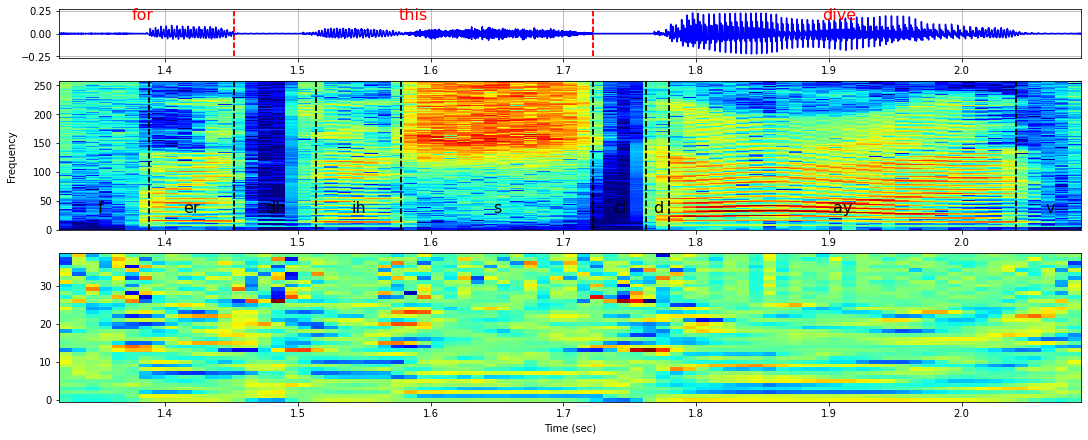

In [11]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################
fig = pyspch.display.PlotSpgFtrs(wavdata=audio, spgdata=spg,dy=1,
                frames=frames, sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=1, ypos=.15, color='k') 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=audio,rate=sr))

### GMM Recognition

In [13]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
# select features to use for GMM processing
ftrs_gmm = ftrs[0:26,:]
# compute posterior probs in the model
y_gmm_prob = clf_GMM.predict_proba(X=ftrs_gmm.T,priors=[1]*41)
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(y_gmm_prob, axis=1)
y_gmm_lab = [classes[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=features.T)
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == labels[i] for i in range(len(labels))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(labels)))

Frame Recognition Rate (for full utterance): 52.99 %


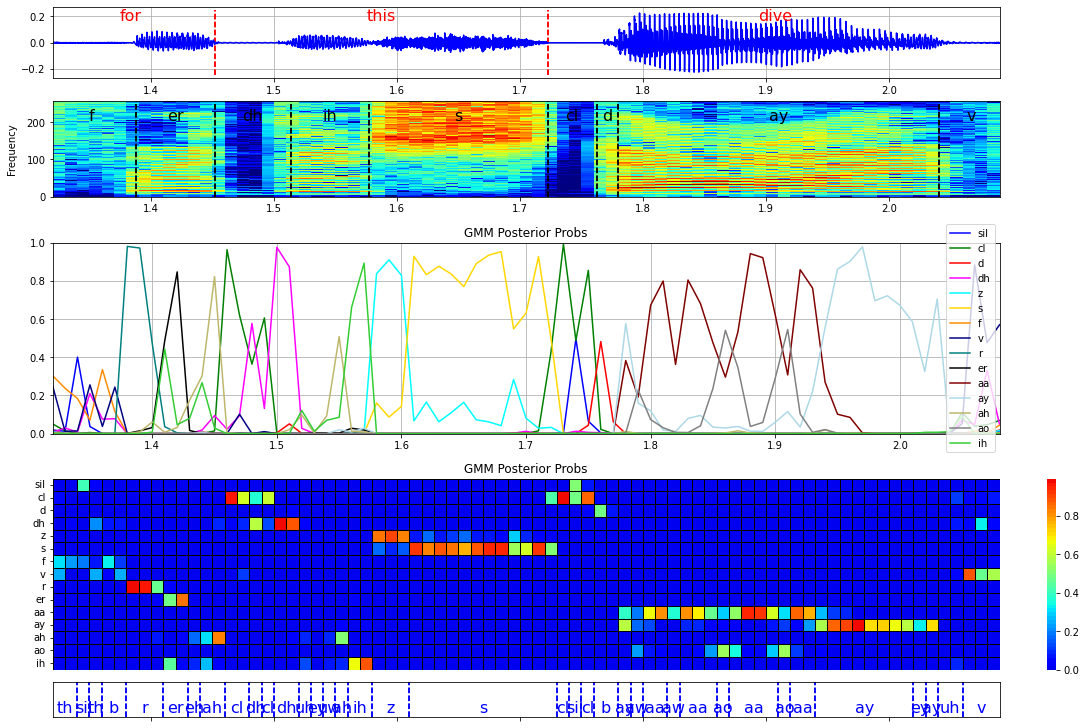

In [14]:
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=audio, spgdata=spg,dy=1,row_heights=[1.5,2,4,4,.75],
                                 frames=frames, sample_rate=sr, figsize=(15,10), img_ftrs=[None,None])
fig.add_seg_plot(seg_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="line", title="GMM Posterior Probs")
plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="img", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_seg, iax=4, ypos=.25, Lines=True, color='b') # predicted labels
fig

### DNN Recognition

In [15]:
# splice features for DNN processing
#
ftrs_dnn = pyspch.sp.splice_frames(ftrs,setup.sampler_args['N'], setup.sampler_args['stride']) # input
# input and target to tensor
X = torch.tensor(ftrs_dnn).T.float().to(device)
y = torch.tensor(labidx).long().to(device)

# posteriors 
yp_t = model(X) # log probs
yp_t = torch.nn.Softmax(dim=1)(yp_t) # probs

# predicted labels (as numpy array) and as segmentation
y_dnn_prob = yp_t.cpu().detach().numpy()
y_dnn_idx = np.argmax(y_dnn_prob, axis=1)
y_dnn_lab = np.vectorize(idx2lab.get)(y_dnn_idx)
y_dnn_seg = pyspch.lbls2seg(y_dnn_lab)
n_corr = np.sum([y_dnn_lab[i] == labels[i] for i in range(len(labels))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(labels)))

Frame Recognition Rate (for full utterance): 70.94 %


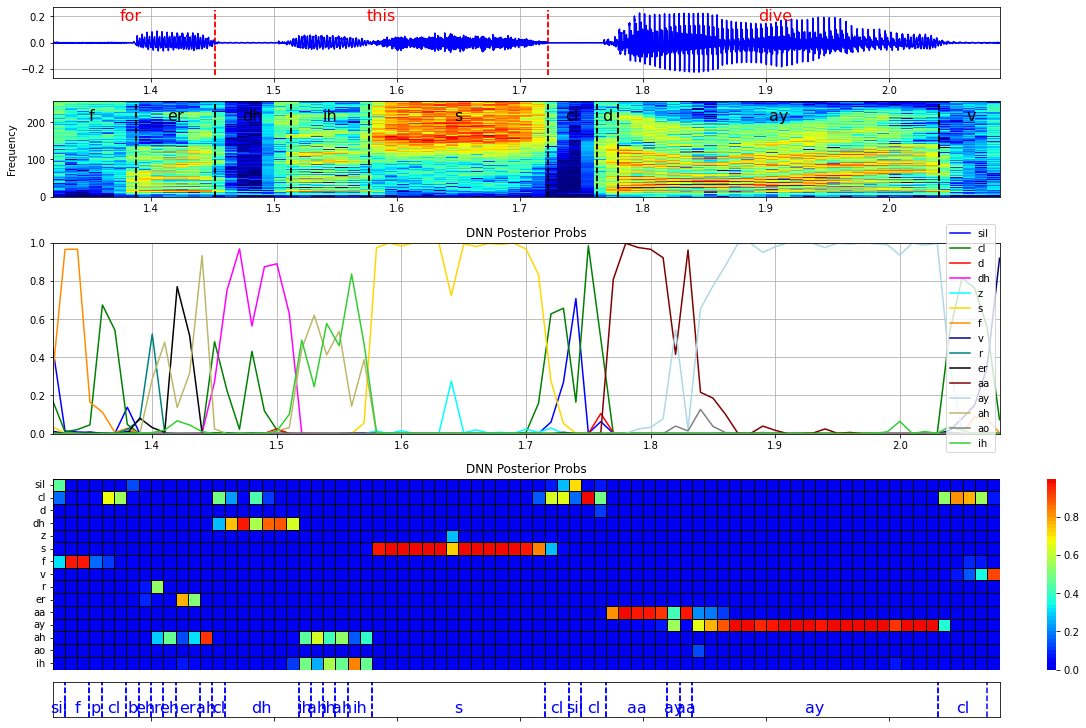

In [16]:
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=audio, spgdata=spg,dy=1,row_heights=[1.5,2,4,4,.75],
                                 frames=frames, sample_rate=sr, figsize=(15,10), img_ftrs=[None,None])
fig.add_seg_plot(seg_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, Lines=True, color='r')

plot_probs(y_dnn_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="line", title="DNN Posterior Probs")
plot_probs(y_dnn_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="img", title="DNN Posterior Probs")

fig.add_seg_plot(y_dnn_seg, iax=4, ypos=.25, Lines=True, color='b') # predicted labels
fig

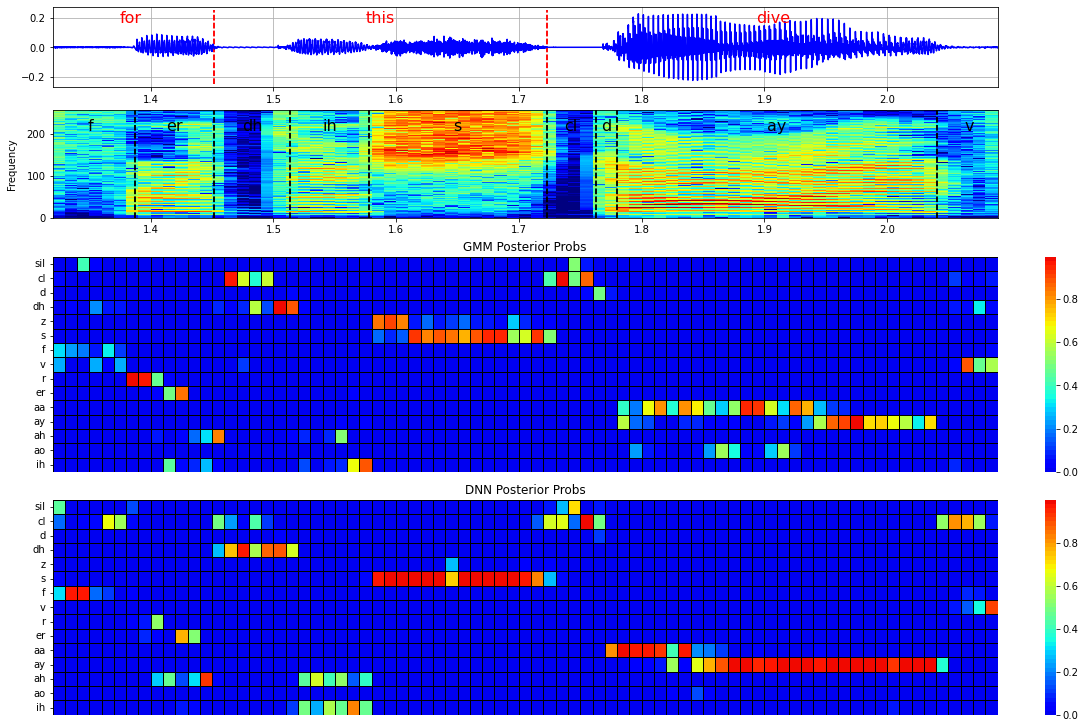

In [17]:
## Compare GMM and DNN outputs
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=audio, spgdata=spg,dy=1,row_heights=[1.5,2,4,4],
                                 frames=frames, sample_rate=sr, figsize=(15,10), img_ftrs=[None,None])
fig.add_seg_plot(seg_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, Lines=True, color='r')

plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="img", title="GMM Posterior Probs")
plot_probs(y_dnn_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="img", title="DNN Posterior Probs")

fig

## 3. Corpus Evaluation

In [18]:
test_data = get_timit_test_data(feature_args=feature_args)

In [19]:
def test_GMM(clf_GMM,X_test,y_test,priors=None,norm=False,Verbose=False):
    try:
        if priors == 'uniform':
            priors = [1]*clf_GMM.n_classes
        elif priors == 'training':
            priors = None
    except:
        pass
    y_pred = clf_GMM.predict(X_test,priors=priors)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    conf_mat = skmetrics.confusion_matrix(y_test,y_pred,labels=clf_GMM.classes)
    if Verbose:
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
        xx =  clf_GMM.n_classes/4. 
        Spch.plot_confusion_matrix(conf_mat,labels=clf_GMM.classes,norm=norm,figsize=(xx+3,xx+3),annot_kws={'fontsize':8})
    return(acc_test,conf_mat)

In [20]:
X_test = test_data.get_features_as_numpy()[:,0:26]
y_test = test_data.get_labels_as_numpy() 
test_models = [ 'GMM_TIMIT_MINI_D26_G8.pk',
               'GMM_TIMIT_D26_G8.pk',
               'GMM_TIMIT_D26_G64.pk']
for clf_name in test_models:
    clf_GMM = get_pickle(clf_name) 
    acc,cm = test_GMM(clf_GMM,X_test,y_test)
    print("MODEL( %s ): %.2f%% correct" % (clf_name,acc) )

MODEL( GMM_TIMIT_MINI_D26_G8.pk ): 48.27% correct
MODEL( GMM_TIMIT_D26_G8.pk ): 52.46% correct
MODEL( GMM_TIMIT_D26_G64.pk ): 56.23% correct


In [21]:
def test_DNN(model,test_data): 
    test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)
    # -- already done when importing test_data ?? test_ds.map_target(lab2lab) # timit61 -> timit41
    test_ds.encode_target(lab2idx) # one-hot encoding
    test_ds.to_tensor()
    # Sampler (splicing)
    test_lengths = test_data.get_length('features')
    test_ds.set_sampler(test_lengths, setup.sampler_args)
    test_ds.to_device(device)

    # DataLoader
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)    
    cm = pyspch.nn.evaluate_cm(model, test_dl) 
    per, per_pc = pyspch.nn.cm2per(cm)
    #print("PER %.2f " % (per))
    return( 100.*(1-per), cm)

In [22]:
test_models = [ 'models/default/mfcc13dd2mv/N0s1/' ,
               'models/default/mfcc13dd2mv/N5s2/' ]

for name in test_models:
    # read checkpoint 
    model_fobj = pyspch.read_fobj(root_url + name + 'model.pt')
    checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)
    # unpack checkpoint (model, etc)
    setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
    # readout for one-hot encoding 
    idx2lab = {v: k for k, v in lab2idx.items()}

    setup = dotdict(setup)
    model.to(device)    
    
    acc,cm = test_DNN(model,test_data)
    print("MODEL( %s ): %.2f%% correct" % (name,acc) )   

MODEL( models/default/mfcc13dd2mv/N0s1/ ): 65.44% correct
MODEL( models/default/mfcc13dd2mv/N5s2/ ): 76.24% correct
